<a href="https://colab.research.google.com/github/theoVasilas/Diplomatic_incident/blob/simulation/Fed_3_2_diabites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [103]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision

In [104]:
from collections import OrderedDict, Counter
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset, logging
from datasets.utils.logging import disable_progress_bar

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg, FedAdagrad
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context


DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.12.0 / PyTorch 2.5.1+cu121


# Dataloader


## Partition loader


In [105]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

BATCH_SIZE = 32  # Adjust as needed

def load_datasets(partition_id: int, num_partitions: int):
    # Load the Pima Indians Diabetes dataset
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    column_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
                    "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
    data = pd.read_csv(url, header=None, names=column_names)

    # Split features and labels
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values

    # Normalize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)

    # Partition the data into `num_partitions`
    dataset = TensorDataset(X_tensor, y_tensor)
    total_size = len(dataset)
    partition_size = total_size // num_partitions

    # Determine indices for this partition
    start_idx = partition_id * partition_size
    end_idx = total_size if partition_id == num_partitions - 1 else (partition_id + 1) * partition_size
    partition_indices = list(range(start_idx, end_idx))

    # Split the partition into training and validation (80% train, 20% val)
    train_size = int(0.8 * len(partition_indices))
    val_size = len(partition_indices) - train_size
    train_indices = partition_indices[:train_size]
    val_indices = partition_indices[train_size:]

    # Create subsets
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    # Create DataLoaders for train and validation
    trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return trainloader, valloader

## test set loader


In [106]:
def load_testset():
    # Load the full test set (centralized)
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    column_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
                    "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
    data = pd.read_csv(url, header=None, names=column_names)

    # Split features and labels
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values

    # Normalize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)

    # Create a TensorDataset and DataLoader for the test set
    test_dataset = TensorDataset(X_tensor, y_tensor)
    testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return testloader

## Histogram of the dataset


In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_raw_partition(partition_id: int, num_partitions: int):
    # Load the Pima Indians Diabetes dataset
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    column_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
                    "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
    data = pd.read_csv(url, header=None, names=column_names)

    # Drop the label column for features
    features = data.iloc[:, :-1].values
    labels = data.iloc[:, -1].values

    # Partition the data
    total_size = len(features)
    partition_size = total_size // num_partitions
    start_idx = partition_id * partition_size
    end_idx = total_size if partition_id == num_partitions - 1 else (partition_id + 1) * partition_size

    partition_features = features[start_idx:end_idx]
    partition_labels = labels[start_idx:end_idx]

    return partition_features, partition_labels

def plot_histograms(partition_features):
    # Create histograms for all features
    num_features = partition_features.shape[1]
    feature_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
                     "BMI", "DiabetesPedigreeFunction", "Age"]

    plt.figure(figsize=(12, 10))
    for i in range(num_features):
        plt.subplot(3, 3, i + 1)
        plt.hist(partition_features[:, i], bins=20, color='blue', alpha=0.7, edgecolor='black')
        plt.title(feature_names[i])
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.suptitle("Histograms of Partition Features", fontsize=16, y=1.02)
    plt.show()

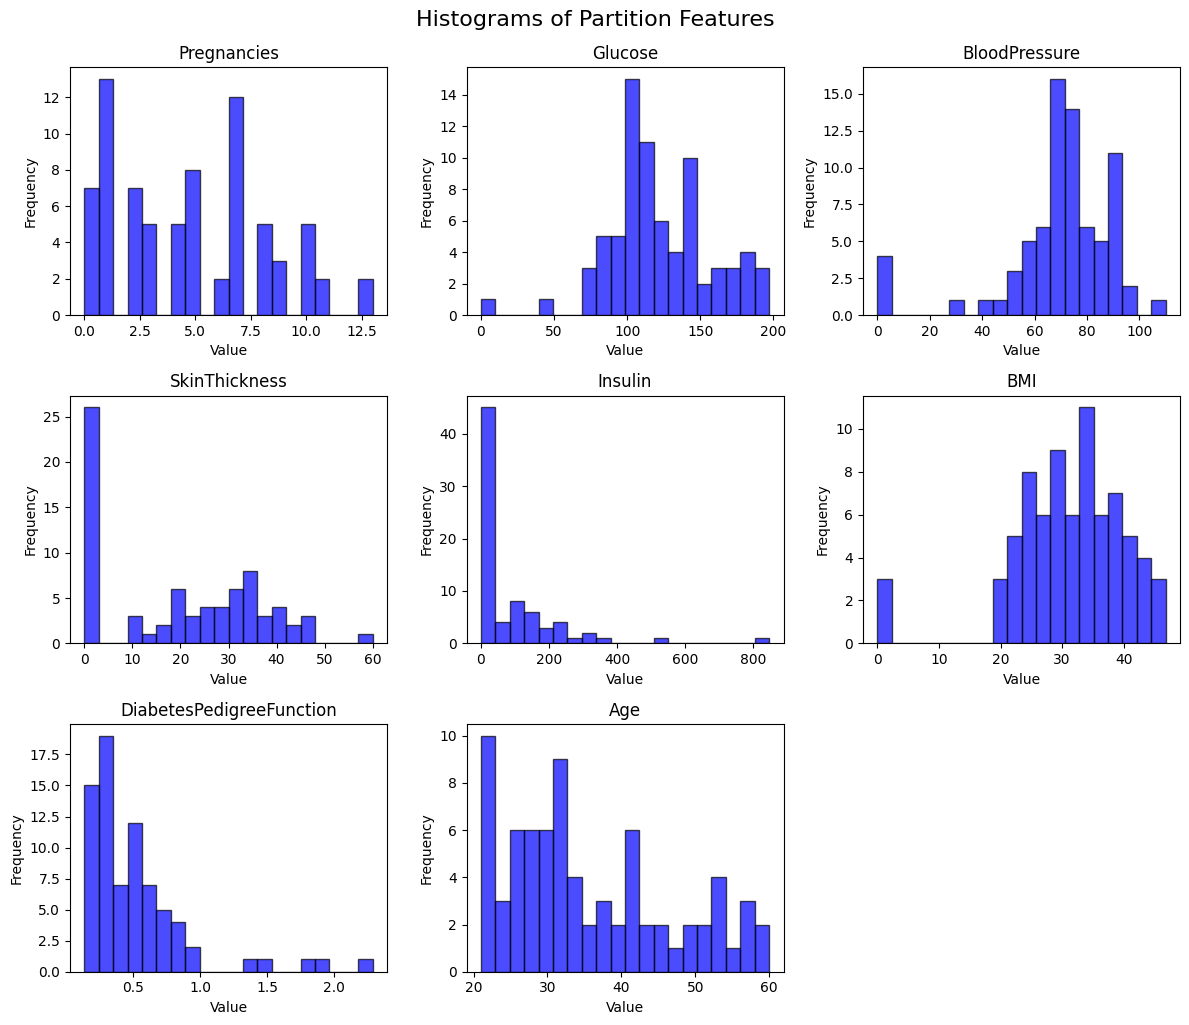

In [108]:
# Load raw data for partition 0
partition_id = 0
num_partitions = 10
partition_features, _ = load_raw_partition(partition_id, num_partitions)

# Plot histograms for the features in the partition
plot_histograms(partition_features)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


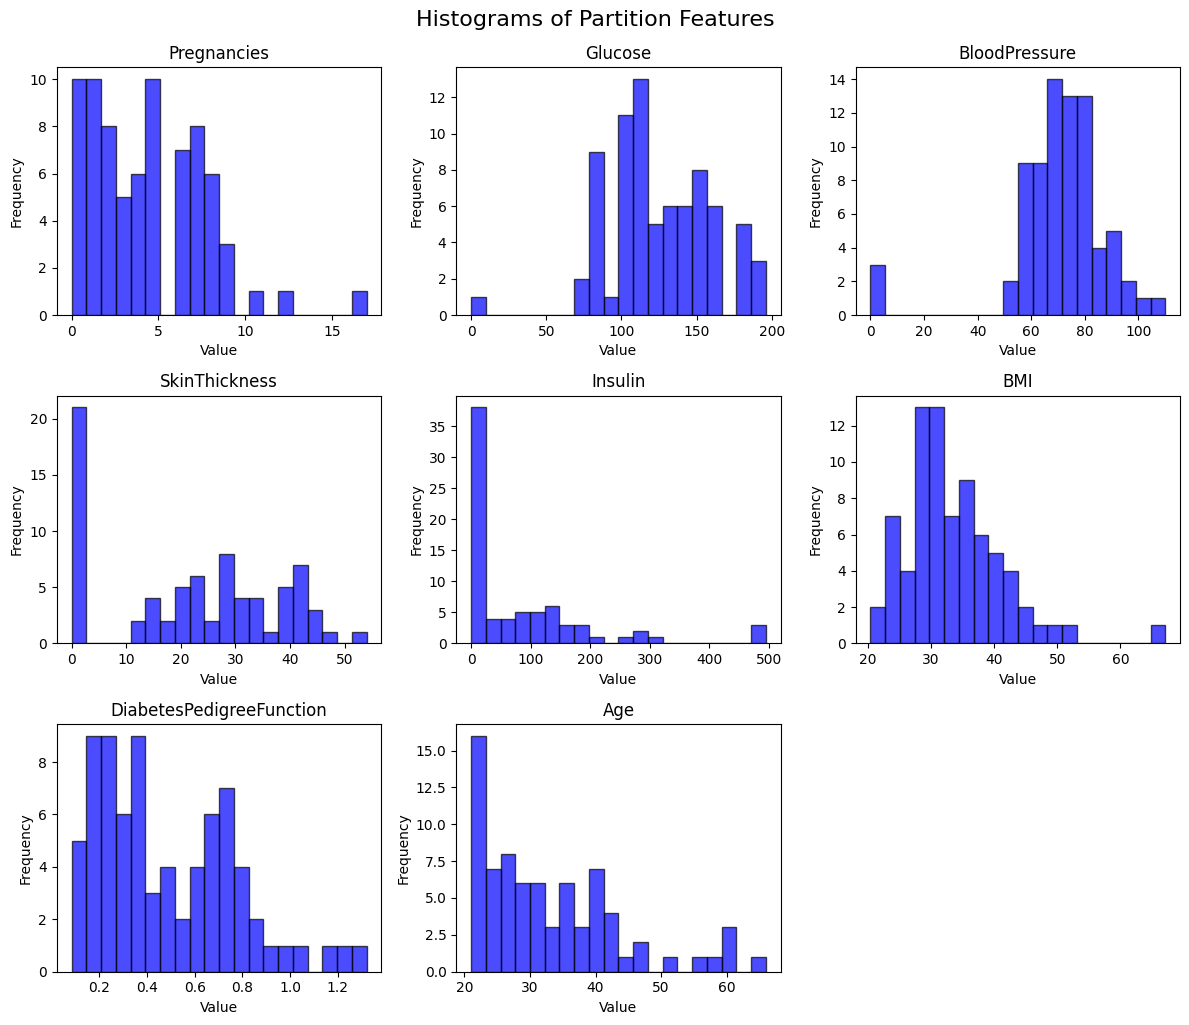

In [109]:
# Load raw data for partition 0
partition_id = 2
num_partitions = 10
partition_features, _ = load_raw_partition(partition_id, num_partitions)

# Plot histograms for the features in the partition
plot_histograms(partition_features)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


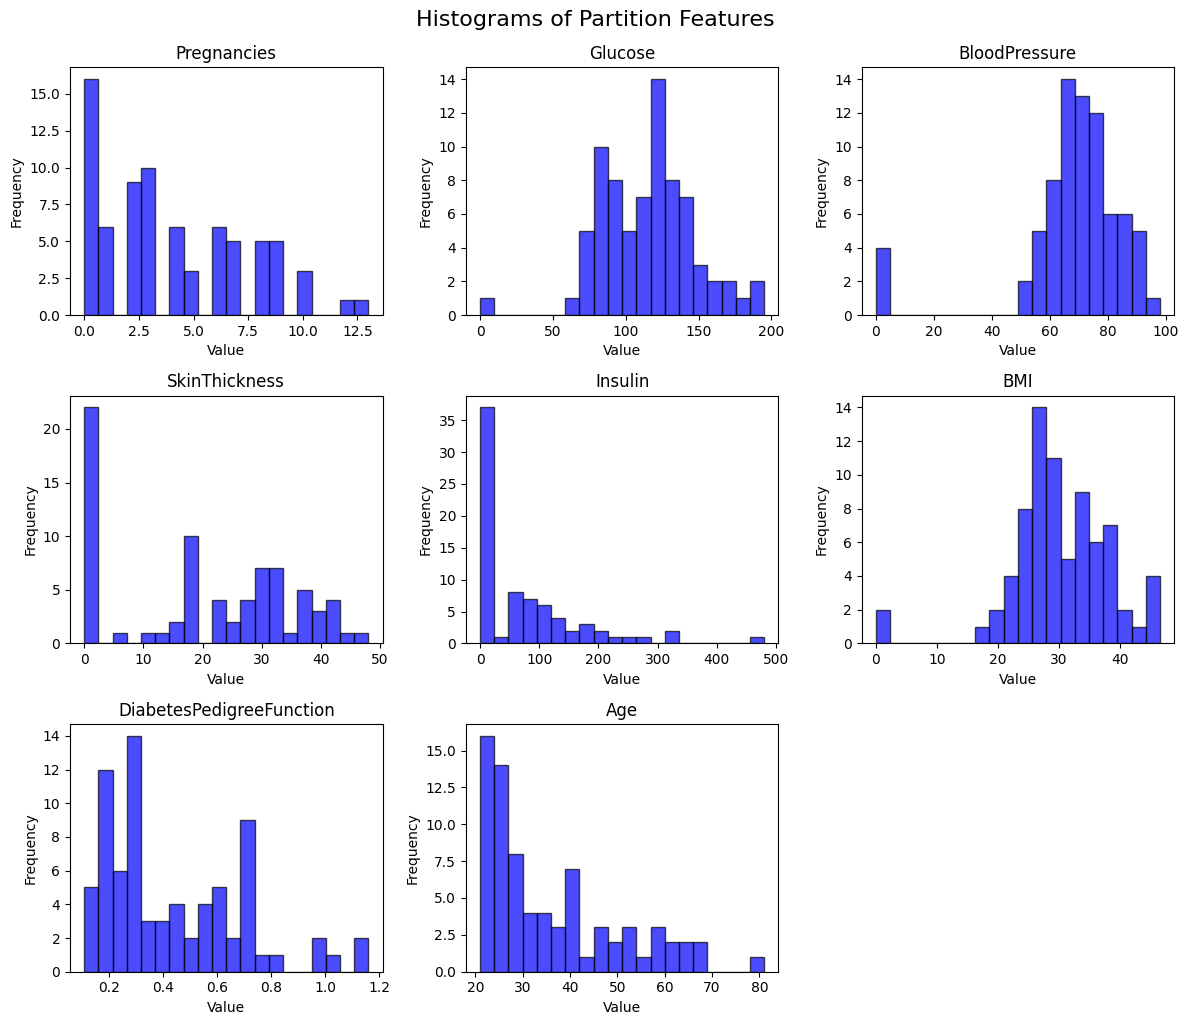

In [110]:
# Load raw data for partition 0
partition_id = 6
num_partitions = 10
partition_features, _ = load_raw_partition(partition_id, num_partitions)

# Plot histograms for the features in the partition
plot_histograms(partition_features)

the partitions has non IID datasets

# Model

In [111]:
import torch.nn.init as init

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.elu(self.fc1(x), alpha=1.0)
        x = F.elu(self.fc2(x), alpha=1.0)
        x = self.fc3(x)  # Logit output
        return x

    def reset_parameters(self):
      for layer in self.children():
          if isinstance(layer, nn.Linear):
              init.xavier_uniform_(layer.weight)  # Using Xavier initialization for weights
              init.zeros_(layer.bias)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [112]:
net = Net()
num_parameters = sum(value.numel() for value in net.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 2689


# train test Func


In [113]:
def train(net, trainloader, optimizer, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.BCEWithLogitsLoss()  # Binary classification loss
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for features, labels in trainloader:
            features, labels = features.to(DEVICE), labels.float().to(DEVICE)  # Labels must be float for BCE
            optimizer.zero_grad()

            outputs = net(features).squeeze(1)  # Squeeze for compatibility with BCEWithLogitsLoss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Metrics
            epoch_loss += loss.item()
            total += labels.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).int()  # Sigmoid for binary predictions
            correct += (predicted == labels.int()).sum().item()

        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch + 1}: train loss {epoch_loss:.4f}, accuracy {epoch_acc:.4f}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.BCEWithLogitsLoss()  # Binary classification loss
    correct, total, loss = 0, 0, 0.0

    net.eval()
    with torch.no_grad():
        for features, labels in testloader:
            features, labels = features.to(DEVICE), labels.float().to(DEVICE)
            outputs = net(features).squeeze(1)

            loss += criterion(outputs, labels).item()
            predicted = (torch.sigmoid(outputs) > 0.5).int()  # Sigmoid for binary predictions
            total += labels.size(0)
            correct += (predicted == labels.int()).sum().item()

    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy


# centralised

In [114]:
def run_centralised(
    trainloader,
    valloader,
    testloader,
    epochs: int,
    lr: float,
    momentum: float = 0.9
):

    # instantiate the model
    model = Net().to(DEVICE)
    model.reset_parameters()

    # optim = torch.optim.Adam(net.parameters())
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    print(f"Training for {epochs} epochs...")
    train(model, trainloader, optim, epochs, verbose =True)
    loss, accuracy = test(model, valloader)
    print(f"validation loss {loss}, accuracy {accuracy}")

    loss, accuracy = test(model, testloader)
    print(f"test {loss = }")
    print(f"test {accuracy = }")

In [115]:
trainloader, valloader = load_datasets(0, 1)

testloader = load_testset()

# Run the centralised training
run_centralised(trainloader, valloader, testloader, epochs=50, lr=0.1)

Training for 50 epochs...
Epoch 1: train loss 0.0176, accuracy 0.7313
Epoch 2: train loss 0.0158, accuracy 0.7590
Epoch 3: train loss 0.0157, accuracy 0.7801
Epoch 4: train loss 0.0161, accuracy 0.7541
Epoch 5: train loss 0.0155, accuracy 0.7687
Epoch 6: train loss 0.0154, accuracy 0.7736
Epoch 7: train loss 0.0156, accuracy 0.7801
Epoch 8: train loss 0.0156, accuracy 0.7736
Epoch 9: train loss 0.0154, accuracy 0.7606
Epoch 10: train loss 0.0152, accuracy 0.7687
Epoch 11: train loss 0.0150, accuracy 0.7850
Epoch 12: train loss 0.0141, accuracy 0.7883
Epoch 13: train loss 0.0145, accuracy 0.7915
Epoch 14: train loss 0.0146, accuracy 0.7964
Epoch 15: train loss 0.0146, accuracy 0.7850
Epoch 16: train loss 0.0145, accuracy 0.7866
Epoch 17: train loss 0.0147, accuracy 0.7899
Epoch 18: train loss 0.0148, accuracy 0.7801
Epoch 19: train loss 0.0144, accuracy 0.7752
Epoch 20: train loss 0.0149, accuracy 0.7948
Epoch 21: train loss 0.0142, accuracy 0.7915
Epoch 22: train loss 0.0148, accuracy 

# Federation

## set-get params


In [116]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    # replace the parameters
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    """Extract model parameters as a list of NumPy arrays."""
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## FlowerClient

In [117]:
class FlowerClient(NumPyClient):
    def __init__(self, pid, net, trainloader, valloader):
        self.pid = pid  # partition ID of a client
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.pid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.pid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)

        optim = torch.optim.SGD(self.net.parameters(), lr=0.01, momentum=0.9)
        train(self.net, self.trainloader,optim , epochs=local_epochs)

        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):

        print(f"[Client {self.pid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)

        loss, accuracy = test(self.net, self.valloader)

        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:

    net = Net().to(DEVICE)

    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]

    trainloader, valloader = load_datasets(partition_id, num_partitions)

    # print(f"FlowerClient is created")
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

## Agregation Function

In [118]:
Agregation_history = []

def My_weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:

    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    losses = [num_examples * m.get("loss", 0.0) for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    accuracy = sum(accuracies) / sum(examples)
    loss = sum(losses) / sum(examples)

    # Save metrics to history
    Agregation_history.append({
        # "round": server_round,
        "loss": loss,
        "accuracy": accuracy
    })

    print(f"My_weighted_average -{accuracy} {loss} ")

    return {"accuracy": accuracy, "loss": loss}

## Server Evaluate metrics aggregation fn

In [119]:
evaluation_history = []

def My_evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:

    net = Net().to(DEVICE)

    testloader = load_testset()

    set_parameters(net, parameters)  # Update model with the latest parameters

    loss, accuracy = test(net, testloader)

    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")

    # Save metrics to history
    evaluation_history.append({
        "round": server_round,
        "loss": loss,
        "accuracy": accuracy
    })

    if accuracy >= 0.98:
        print(f"Target accuracy of { 0.98*100}% achieved. Stopping training.")
        return fl.server.EarlyStopping()

    model_filename = f"federated_model_{server_round}.pth"
    torch.save(net.state_dict(), model_filename)
    print(f"Model saved as {model_filename}")

    return loss, {"accuracy": accuracy}


## Server Fn Strategy

In [120]:
def fit_config(server_round: int):
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 5 ,
    }
    return config

In [121]:
NUM_CLIENTS = 10

In [122]:
NUM_ROUNDS = 30

In [123]:
params = get_parameters(Net())

In [124]:
def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit  = 1,
        fraction_evaluate = 1,
        min_fit_clients  =  5,
        min_evaluate_clients  = 2,
        min_available_clients = NUM_CLIENTS, # use all
        evaluate_fn = My_evaluate, # function used for validation dy server
        on_fit_config_fn  = fit_config,  # Pass the fit_config function
        # on_evaluate_config_fn,
        # accept_failures,
        initial_parameters  = ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn =  My_weighted_average,
        # inplace,
    )

    config = ServerConfig(num_rounds = NUM_ROUNDS)

    return ServerAppComponents(strategy=strategy, config = config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

## RUN


In [125]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=30, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.022276054524506133, {'accuracy': 0.38671875}
INFO :      
INFO :      [ROUND 1]


Server-side evaluation loss 0.022276054524506133 / accuracy 0.38671875
Model saved as federated_model_0.pth


INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(pid=13401) 2024-11-20 12:12:45.271458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=13401) 2024-11-20 12:12:45.317303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=13401) 2024-11-20 12:12:45.330956: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=13401) 2024-11-20 12:12:48.603384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(ClientAppActor pid=13401) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 5}
(ClientAppActor pid=13401) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 5} [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (1, 0.020722786352659266, {'accuracy': 0.6627604166666666}, 45.36275512300017)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.020722786352659266 / accuracy 0.6627604166666666
Model saved as federated_model_1.pth
(ClientAppActor pid=13400) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.6636029411764706 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (2, 0.019533563405275345, {'accuracy': 0.7005208333333334}, 46.960517623000214)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.019533563405275345 / accuracy 0.7005208333333334
Model saved as federated_model_2.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7011029411764705 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (3, 0.018617147967840236, {'accuracy': 0.7239583333333334}, 48.511705669000094)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.018617147967840236 / accuracy 0.7239583333333334
Model saved as federated_model_3.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7202205882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (4, 0.017861079424619675, {'accuracy': 0.7330729166666666}, 50.02991236800017)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.017861079424619675 / accuracy 0.7330729166666666
Model saved as federated_model_4.pth
(ClientAppActor pid=13401) [Client 6, round 4] fit, config: {'server_round': 4, 'local_epochs': 5} [repeated 32x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=13400) [Client 0] evaluate, config: {} [repeated 38x across cluster]
My_weighted_average -0.7202205882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (5, 0.01724552906428774, {'accuracy': 0.73828125}, 51.47988119799993)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.01724552906428774 / accuracy 0.73828125
Model saved as federated_model_5.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7264705882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (6, 0.01678452097500364, {'accuracy': 0.7317708333333334}, 53.10851972699993)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.01678452097500364 / accuracy 0.7317708333333334
Model saved as federated_model_6.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7139705882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (7, 0.01634635093311469, {'accuracy': 0.734375}, 55.03168841800016)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.01634635093311469 / accuracy 0.734375
Model saved as federated_model_7.pth
(ClientAppActor pid=13401) [Client 5, round 7] fit, config: {'server_round': 7, 'local_epochs': 5} [repeated 30x across cluster]
(ClientAppActor pid=13400) [Client 8] evaluate, config: {} [repeated 26x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7202205882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (8, 0.016029453099084396, {'accuracy': 0.7421875}, 57.25084031899996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.016029453099084396 / accuracy 0.7421875
Model saved as federated_model_8.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7202205882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (9, 0.015763529964412253, {'accuracy': 0.74609375}, 59.02319600200008)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.015763529964412253 / accuracy 0.74609375
Model saved as federated_model_9.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7264705882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=13400) [Client 6, round 10] fit, config: {'server_round': 10, 'local_epochs': 5} [repeated 27x across cluster]


INFO :      fit progress: (10, 0.01555931354717662, {'accuracy': 0.7447916666666666}, 60.54128629900015)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.01555931354717662 / accuracy 0.7447916666666666
Model saved as federated_model_10.pth
(ClientAppActor pid=13400) [Client 0] evaluate, config: {} [repeated 26x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7327205882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (11, 0.015417928652216991, {'accuracy': 0.7513020833333334}, 61.90674769199995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.015417928652216991 / accuracy 0.7513020833333334
Model saved as federated_model_11.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7514705882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (12, 0.015268870474149784, {'accuracy': 0.7565104166666666}, 63.43445384200004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.015268870474149784 / accuracy 0.7565104166666666
Model saved as federated_model_12.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7577205882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (13, 0.015148841814758876, {'accuracy': 0.7578125}, 65.00832267600026)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.015148841814758876 / accuracy 0.7578125
Model saved as federated_model_13.pth
(ClientAppActor pid=13401) [Client 4, round 13] fit, config: {'server_round': 13, 'local_epochs': 5} [repeated 33x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7577205882352941 0.0 
(ClientAppActor pid=13401) [Client 9] evaluate, config: {} [repeated 39x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (14, 0.015052487996096412, {'accuracy': 0.7565104166666666}, 66.47549673799995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.015052487996096412 / accuracy 0.7565104166666666
Model saved as federated_model_14.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7577205882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (15, 0.015009659575298429, {'accuracy': 0.7604166666666666}, 67.95479600099998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.015009659575298429 / accuracy 0.7604166666666666
Model saved as federated_model_15.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7577205882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (16, 0.014983369774806002, {'accuracy': 0.7630208333333334}, 70.0412806280001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.014983369774806002 / accuracy 0.7630208333333334
Model saved as federated_model_16.pth
(ClientAppActor pid=13400) [Client 7, round 16] fit, config: {'server_round': 16, 'local_epochs': 5} [repeated 30x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=13400) [Client 3] evaluate, config: {} [repeated 27x across cluster]
My_weighted_average -0.7577205882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (17, 0.014939274988137186, {'accuracy': 0.7669270833333334}, 72.4348446150002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.014939274988137186 / accuracy 0.7669270833333334
Model saved as federated_model_17.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7514705882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (18, 0.014874486873547236, {'accuracy': 0.765625}, 73.91458016200022)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.014874486873547236 / accuracy 0.765625
Model saved as federated_model_18.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7573529411764706 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (19, 0.014850241248495877, {'accuracy': 0.7669270833333334}, 75.52693480700009)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.014850241248495877 / accuracy 0.7669270833333334
Model saved as federated_model_19.pth
(ClientAppActor pid=13401) [Client 2, round 19] fit, config: {'server_round': 19, 'local_epochs': 5} [repeated 30x across cluster]
(ClientAppActor pid=13400) [Client 5] evaluate, config: {} [repeated 26x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7636029411764705 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (20, 0.014811266291265687, {'accuracy': 0.7682291666666666}, 76.9728331350002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.014811266291265687 / accuracy 0.7682291666666666
Model saved as federated_model_20.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7636029411764705 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (21, 0.014784030926724276, {'accuracy': 0.765625}, 78.53672282900015)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.014784030926724276 / accuracy 0.765625
Model saved as federated_model_21.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7636029411764705 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (22, 0.014751634793356061, {'accuracy': 0.7643229166666666}, 79.96734827)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.014751634793356061 / accuracy 0.7643229166666666
Model saved as federated_model_22.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7636029411764705 0.0 
(ClientAppActor pid=13400) [Client 3, round 23] fit, config: {'server_round': 23, 'local_epochs': 5} [repeated 31x across cluster]
(ClientAppActor pid=13401) [Client 9] evaluate, config: {} [repeated 37x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (23, 0.014732192076432208, {'accuracy': 0.765625}, 81.43636790100027)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.014732192076432208 / accuracy 0.765625
Model saved as federated_model_23.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7636029411764705 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (24, 0.014713957828159133, {'accuracy': 0.765625}, 83.08497243900001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.014713957828159133 / accuracy 0.765625
Model saved as federated_model_24.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7639705882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (25, 0.014691585946517685, {'accuracy': 0.7630208333333334}, 85.36982433100002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.014691585946517685 / accuracy 0.7630208333333334
Model saved as federated_model_25.pth
(ClientAppActor pid=13401) [Client 6, round 25] fit, config: {'server_round': 25, 'local_epochs': 5} [repeated 29x across cluster]
(ClientAppActor pid=13401) [Client 9] evaluate, config: {} [repeated 25x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7577205882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (26, 0.014677544978136817, {'accuracy': 0.7669270833333334}, 87.44451249600024)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.014677544978136817 / accuracy 0.7669270833333334
Model saved as federated_model_26.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7639705882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (27, 0.01464737947875013, {'accuracy': 0.7669270833333334}, 88.91185331299994)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.01464737947875013 / accuracy 0.7669270833333334
Model saved as federated_model_27.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7577205882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (28, 0.014627510371307531, {'accuracy': 0.7669270833333334}, 90.35623676700015)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.014627510371307531 / accuracy 0.7669270833333334
Model saved as federated_model_28.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=13401) [Client 7, round 28] fit, config: {'server_round': 28, 'local_epochs': 5} [repeated 30x across cluster]
My_weighted_average -0.7577205882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (29, 0.014624706702306867, {'accuracy': 0.76953125}, 91.7281103270002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=13401) [Client 1] evaluate, config: {} [repeated 35x across cluster]
Server-side evaluation loss 0.014624706702306867 / accuracy 0.76953125
Model saved as federated_model_29.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7639705882352941 0.0 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (30, 0.01460625413650026, {'accuracy': 0.7669270833333334}, 93.15937245100031)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.01460625413650026 / accuracy 0.7669270833333334
Model saved as federated_model_30.pth


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 93.80s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.041321122931206926
INFO :      		round 2: 0.03894906458170975
INFO :      		round 3: 0.037103795391671794
INFO :      		round 4: 0.035575999012764765
INFO :      		round 5: 0.03432878966936294
INFO :      		round 6: 0.033364405614488266
INFO :      		round 7: 0.032456444740733684
INFO :      		round 8: 0.03175534566535669
INFO :      		round 9: 0.031203916898983365
INFO :      		round 10: 0.0307387831456521
INFO :      		round 11: 0.030403695759527827
INFO :      		round 12: 0.030036080760114336
INFO :      		round 13: 0.02973630093038082
INFO :      		round 14: 0.029457214485634774
INFO :      		round 15: 0.029381583543384777
INFO :      		round 16: 0.029364214289714308
INFO :      		round 17: 0.029191439007135
INFO :      		round 18: 0.029013752137475153
INFO :      		rou

My_weighted_average -0.7639705882352941 0.0 


INFO :      	          (27, 0.0),
INFO :      	          (28, 0.0),
INFO :      	          (29, 0.0),
INFO :      	          (30, 0.0)]}
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.38671875),
INFO :      	              (1, 0.6627604166666666),
INFO :      	              (2, 0.7005208333333334),
INFO :      	              (3, 0.7239583333333334),
INFO :      	              (4, 0.7330729166666666),
INFO :      	              (5, 0.73828125),
INFO :      	              (6, 0.7317708333333334),
INFO :      	              (7, 0.734375),
INFO :      	              (8, 0.7421875),
INFO :      	              (9, 0.74609375),
INFO :      	              (10, 0.7447916666666666),
INFO :      	              (11, 0.7513020833333334),
INFO :      	              (12, 0.7565104166666666),
INFO :      	              (13, 0.7578125),
INFO :      	              (14, 0.7565104166666666),
INFO :      	              (15, 0.7604166666666666),
INFO :      	              (16, 

(ClientAppActor pid=13401) [Client 8, round 30] fit, config: {'server_round': 30, 'local_epochs': 5} [repeated 20x across cluster]
(ClientAppActor pid=13401) [Client 8] evaluate, config: {} [repeated 20x across cluster]


(pid=13400) 2024-11-20 12:12:45.271458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=13400) 2024-11-20 12:12:45.317313: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=13400) 2024-11-20 12:12:45.330950: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=13400) 2024-11-20 12:12:48.603384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Metrics

In [126]:
Agregation_history

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'loss': 0.0, 'accuracy': 0.6636029411764706},
 {'loss': 0.0, 'accuracy': 0.7011029411764705},
 {'loss': 0.0, 'accuracy': 0.7202205882352941},
 {'loss': 0.0, 'accuracy': 0.7202205882352941},
 {'loss': 0.0, 'accuracy': 0.7264705882352941},
 {'loss': 0.0, 'accuracy': 0.7139705882352941},
 {'loss': 0.0, 'accuracy': 0.7202205882352941},
 {'loss': 0.0, 'accuracy': 0.7202205882352941},
 {'loss': 0.0, 'accuracy': 0.7264705882352941},
 {'loss': 0.0, 'accuracy': 0.7327205882352941},
 {'loss': 0.0, 'accuracy': 0.7514705882352941},
 {'loss': 0.0, 'accuracy': 0.7577205882352941},
 {'loss': 0.0, 'accuracy': 0.7577205882352941},
 {'loss': 0.0, 'accuracy': 0.7577205882352941},
 {'loss': 0.0, 'accuracy': 0.7577205882352941},
 {'loss': 0.0, 'accuracy': 0.7577205882352941},
 {'loss': 0.0, 'accuracy': 0.7514705882352941},
 {'loss': 0.0, 'accuracy': 0.7573529411764706},
 {'loss': 0.0, 'accuracy': 0.7636029411764705},
 {'loss': 0.0, 'accuracy': 0.7636029411764705},
 {'loss': 0.0, 'accuracy': 0.76360294117

In [127]:
evaluation_history

[{'round': 0, 'loss': 0.022276054524506133, 'accuracy': 0.38671875},
 {'round': 1, 'loss': 0.020722786352659266, 'accuracy': 0.6627604166666666},
 {'round': 2, 'loss': 0.019533563405275345, 'accuracy': 0.7005208333333334},
 {'round': 3, 'loss': 0.018617147967840236, 'accuracy': 0.7239583333333334},
 {'round': 4, 'loss': 0.017861079424619675, 'accuracy': 0.7330729166666666},
 {'round': 5, 'loss': 0.01724552906428774, 'accuracy': 0.73828125},
 {'round': 6, 'loss': 0.01678452097500364, 'accuracy': 0.7317708333333334},
 {'round': 7, 'loss': 0.01634635093311469, 'accuracy': 0.734375},
 {'round': 8, 'loss': 0.016029453099084396, 'accuracy': 0.7421875},
 {'round': 9, 'loss': 0.015763529964412253, 'accuracy': 0.74609375},
 {'round': 10, 'loss': 0.01555931354717662, 'accuracy': 0.7447916666666666},
 {'round': 11, 'loss': 0.015417928652216991, 'accuracy': 0.7513020833333334},
 {'round': 12, 'loss': 0.015268870474149784, 'accuracy': 0.7565104166666666},
 {'round': 13, 'loss': 0.015148841814758876

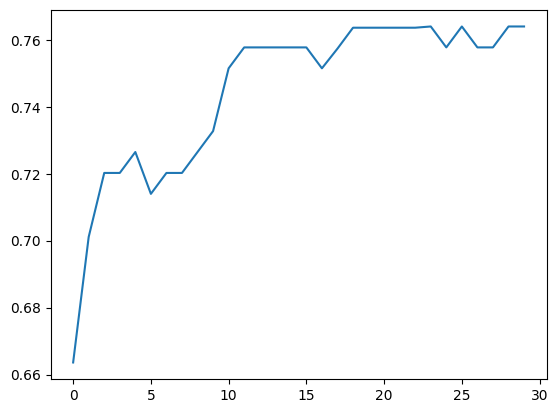

In [128]:
accuracy_values = [d['accuracy'] for d in Agregation_history]
plt.plot(accuracy_values)
plt.show()

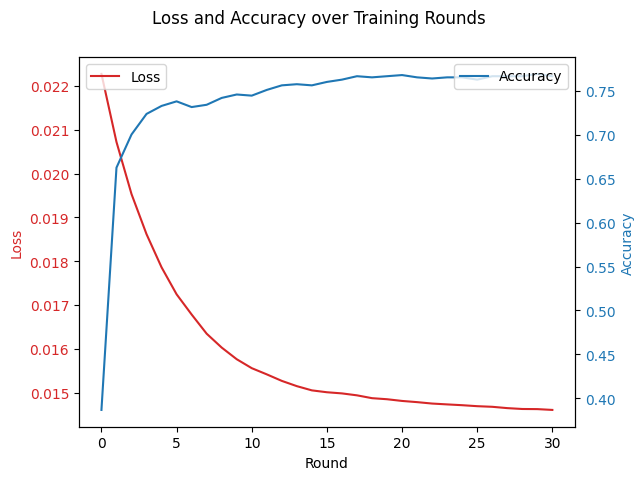

In [129]:
rounds = [entry["round"] for entry in evaluation_history]
loss = [entry["loss"] for entry in evaluation_history]
accuracy = [entry["accuracy"] for entry in evaluation_history]

fig, ax1 = plt.subplots()

# Plot loss on the first y-axis
ax1.set_xlabel("Round")
ax1.set_ylabel("Loss", color="tab:red")
ax1.plot(rounds, loss, color="tab:red", label="Loss")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color="tab:blue")
ax2.plot(rounds, accuracy, color="tab:blue", label="Accuracy")
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Title and legend
fig.suptitle("Loss and Accuracy over Training Rounds")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Show the plot
plt.show()
